In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import os
import tensorflow as tf
seed = 20181122
samples = 2000
is_liner = 0 # 0.linear(default), 1.blobs, 2.moons, 3.circles
features = 2 # 特征数量
n_classes = 3
if is_liner in [1, 2, 3]:
    n_classes = 2
if is_liner == 0:
    data, label = make_classification(n_features=features,
                                      n_clusters_per_class=1, 
                                      n_samples=samples,
                                      n_informative=features,
                                      n_redundant=0,
                                      n_repeated=0,
                                      n_classes=n_classes)
elif is_liner == 1:
    data, label = make_blobs(n_samples=samples, n_features=features, centers=2, random_state=seed)
elif is_liner == 2:
    data, label = make_moons(n_samples=samples, noise=0.1, random_state=seed) # 月牙形状数据集
elif is_liner == 3:
    data, label = make_circles(n_samples=samples, noise=0.1, factor=0.4, random_state=seed) # 圆形数据集
label = label.reshape((len(label), 1))

In [2]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [3]:
def plot_graph(df, n_classes=n_classes, title=""):
    legend = []
    for i in range(n_classes):
        t = train.query(f'label == {i}')
        x, y = t['f0'].values, t['f1'].values
        plt.scatter(x, y)
        legend.append(i)
    plt.legend(legend)
    plt.title(title)
    plt.show()

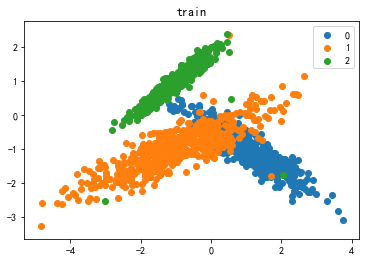

In [4]:
train = pd.DataFrame(X_train, columns=[f'f{i}' for i in range(features)])
train['label'] = y_train
plot_graph(df=train, title='train')

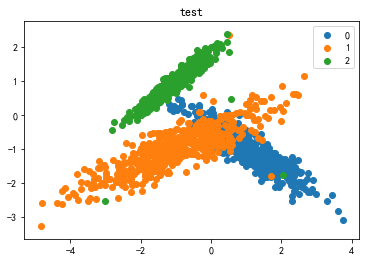

In [5]:
test = pd.DataFrame(X_test, columns=[f'f{i}' for i in range(features)])
test['label'] = y_test
plot_graph(df=test, title='test')

In [6]:
if n_classes >= 2:
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder()
    y_train = ohe.fit_transform(y_train).todense()
    y_test = ohe.transform(y_test).todense()

In [7]:
# 计算训练集合上的均值 最大值 最小值 用来归一化
mean = np.mean(X_train, axis=0)
maxium = np.max(X_train, axis=0)
minium = np.min(X_train, axis=0)

# 归一化
def normalizition(X, maxium=maxium, minium=minium, mean=mean):
    return (X - mean) / (maxium - minium)

X_train = normalizition(X_train)
X_test = normalizition(X_test)

In [8]:
def add_layer(inputs, in_size, out_size, activation_function=tf.nn.relu):
    Weights = tf.Variable(tf.random_normal([in_size, out_size]))
    biases = tf.Variable(tf.zeros([1, out_size]) + 0.1)
    Wx_plus_b = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    return outputs

In [9]:
def predict(X):
    global outputs
    pred_y = sess.run(outputs, feed_dict={xs:X})
    return pred_y

In [10]:
# 绘制决策边界
def plot_decision_boundary(pred_func, X, y):
    # 设定最大最小值，附加一点点边缘填充
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # 用预测函数预测一下
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    # 返回的是概率，转成类别
    if n_classes == 1:
        Z = (Z > 0.5).astype(np.int)
    else:
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape((len(Z), 1))
    Z = Z.reshape(xx.shape)
    # 然后画出图
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=np.array(np.argmax(y, axis=1)).reshape((y.shape[0], )), cmap=plt.cm.Spectral)
#     plt.scatter(X[:, 0], X[:, 1], c=y.reshape((y.shape[0], )), cmap=plt.cm.Spectral)

In [11]:
# metric
def accuracy(label, pred_y):
    return np.mean(label == (pred_y > 0.5).astype(np.int))

In [12]:
xs = tf.placeholder(tf.float32, [None, features])
ys = tf.placeholder(tf.float32, [None, n_classes])
nodes = 20 # 每层节点数
# 输入层
l1 = add_layer(xs, features, nodes)
# 隐藏层
l2 = add_layer(l1, nodes, nodes)
# 输出层, 默认用sigmoid激活, 二分类
outputs = add_layer(l2, nodes, n_classes, activation_function=tf.nn.sigmoid)

# 下面使用tf自带的dense层
# l1 = tf.layers.dense(xs, nodes, tf.nn.relu)
# l2 = tf.layers.dense(l1, nodes, tf.nn.relu)
# outputs = tf.layers.dense(l2, 1, tf.nn.sigmoid)

In [13]:
setting = {'epochs':3000,  # 迭代次数
           'lr':0.001, # 学习率
           'early_stopping':300, # 早停次数 
           'current_epoch':0, # 当前轮次
           'best_score':-np.inf}
train_loss = []
test_loss = []
train_metric = []
test_metric = []

In [14]:
# 清空上一次保存的内容
model_path = './model/'
[os.remove(f'{model_path}{i}') for i in os.listdir(model_path) if not i.startswith('.')]
# 交叉熵loss
loss = tf.losses.sigmoid_cross_entropy(ys, outputs)
# 优化器 这里用的是Adam,tf.train下还有别的优化器
train_step = tf.train.AdamOptimizer(setting['lr']).minimize(loss)
# important step
init = tf.global_variables_initializer()
sess= tf.Session()
sess.run(init)
# 保存模型 max_to_keep 只保存一个模型
saver = tf.train.Saver(max_to_keep=1)
for i in range(setting['epochs']):
    # training
    sess.run(train_step, feed_dict={xs: X_train, ys: y_train})
    # loss
    train_loss.append(sess.run(loss, feed_dict={xs:X_train, ys:y_train}))
    test_loss.append(sess.run(loss, feed_dict={xs:X_test, ys:y_test}))
    # trian metric
    pred_y = sess.run(outputs, feed_dict={xs:X_train})
    train_metric.append(accuracy(y_train, pred_y))
    # test metric
    pred_y = sess.run(outputs, feed_dict={xs:X_test})
    test_metric.append(accuracy(y_test, pred_y))
    # early_stopping
    if test_metric[-1] > setting['best_score']:
        setting['best_score'] = test_metric[-1]
        setting['current_epoch'] = 0
        saver.save(sess, "./model/self-model", global_step=i)
    setting['current_epoch'] += 1
    if setting['early_stopping'] == setting['current_epoch']:
        break
    
    acc = accuracy(label, pred_y)
    if (i + 1) % 50 == 0:
        # to see the step improvement
        print('epoch:', i + 1,
              'train loss:', train_loss[-1], 
              'test loss:', test_loss[-1],
              'train acc:', train_metric[-1],
              'test acc:', test_metric[-1])

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 50 train loss: 0.739236 test loss: 0.746405 train acc: 0.640416666667 test acc: 0.613333333333
epoch: 100 train loss: 0.693367 test loss: 0.703443 train acc: 0.81875 test acc: 0.7825
epoch: 150 train loss: 0.670583 test loss: 0.681517 train acc: 0.836666666667 test acc: 0.805833333333
epoch: 200 train loss: 0.657549 test loss: 0.667148 train acc: 0.845208333333 test acc: 0.825
epoch: 250 train loss: 0.642043 test loss: 0.649127 train acc: 0.866458333333 test acc: 0.8425
epoch: 300 train loss: 0.624882 test loss: 0.629869 train acc: 0.9 test acc: 0.893333333333
epoch: 350 train loss: 0.615789 test loss: 0.62211 train acc: 0.912916666667 test acc: 0.9
epoch: 400 train loss: 0.612091 test loss: 0.618727 train acc: 0.914166666667 test acc: 0.9
epoch: 450 train loss: 0.609927 test loss: 0.616637 train acc: 0.916041666667 test acc: 0.9
epoch: 500 train loss: 0.608412 test loss: 0.61514 train acc: 0.91625 test acc: 0.901666666667
epoch: 550 train loss: 0.607247 test loss: 0.613947 trai

In [15]:
# 加载模型
meta_file = model_path + [i for i in os.listdir(model_path) if 'meta' in i][0]
saver = tf.train.import_meta_graph(meta_file)
saver.restore(sess, tf.train.latest_checkpoint(model_path))

INFO:tensorflow:Restoring parameters from ./model/self-model-1372


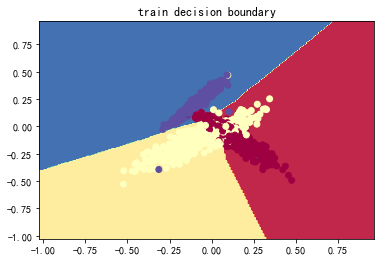

In [16]:
plot_decision_boundary(lambda x : predict(x), X_train, y_train)
plt.title('train decision boundary')
plt.show()

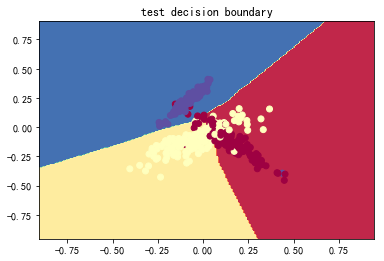

In [17]:
plot_decision_boundary(lambda x : predict(x), X_test, y_test)
plt.title('test decision boundary')
plt.show()

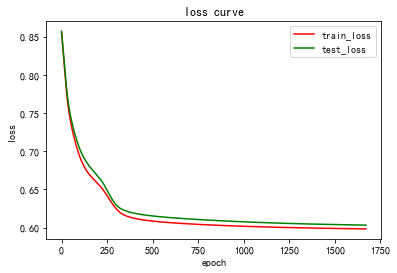

In [18]:
# loss曲线
plt.plot(list(range(len(train_loss))), train_loss, color='r')
plt.plot(list(range(len(test_loss))), test_loss, color='g')
plt.legend(['train_loss', 'test_loss'])
plt.title('loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

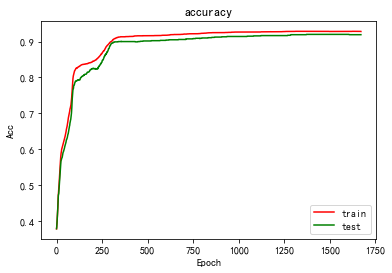

In [19]:
# metric 曲线
plt.plot(list(range(len(train_metric))), train_metric, color='r')
plt.plot(list(range(len(test_metric))), test_metric, color='g')
plt.legend(['train', 'test'])
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()

In [20]:
if nodes == 2:
    t = pd.DataFrame(sess.run(l1, feed_dict={xs:X_train}), columns=[f'f{i}' for i in range(features)])
    t['label'] = y_train
    plot_graph(t)

    t = pd.DataFrame(sess.run(l2, feed_dict={xs:X_train}), columns=[f'f{i}' for i in range(features)])
    t['label'] = y_train
    plot_graph(t)

    t = pd.DataFrame(sess.run(outputs, feed_dict={xs:X_train}), columns=['f0'])
    t['f1'] = y_train
    t['label'] = y_train
    plot_graph(t)